# **Imports**

In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 4.1 MB/s 
     |████████████████████████████████| 77 kB 7.6 MB/s 
     |████████████████████████████████| 6.6 MB 34.7 MB/s 
     |████████████████████████████████| 880 kB 43.2 MB/s 
     |████████████████████████████████| 596 kB 40.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=857e61ff1abf333421f83ca0ae1a9b53a248715e4426ca1eb9e6de2eb01b63a7
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import json
import os
import re
import pandas as pd 
import numpy as np
import random
import time
import datetime
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn import functional as F
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import random_split
torch.manual_seed(42)

from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from transformers import AdamW,  get_linear_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

import warnings
warnings.simplefilter('ignore')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **Utils**

In [ ]:
# reproducibility
def seed_everything(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# **Load dataset**

In [5]:
data = pd.read_csv('/content/drive/My Drive/NLP_humor/data/jokes_dataset_MAIN_PREPROC.csv', 
                 sep=',', 
                 encoding='utf-8')

In [6]:
data.head()

,id,joke,rank
0,5tz52q,I hate how you cannot even say black paint any...,1
1,5tz4dd,What is the difference between a Jew in Nazi G...,0
2,5tz319,I recently went to America..... ...and being t...,0
3,5tz2wj,"Brian raises his hand and says, ""He is in Heav...",1
4,5tz1pc,You hear about the University book store worke...,0


In [7]:
data['Text_length'] = data.joke.str.split().str.len()

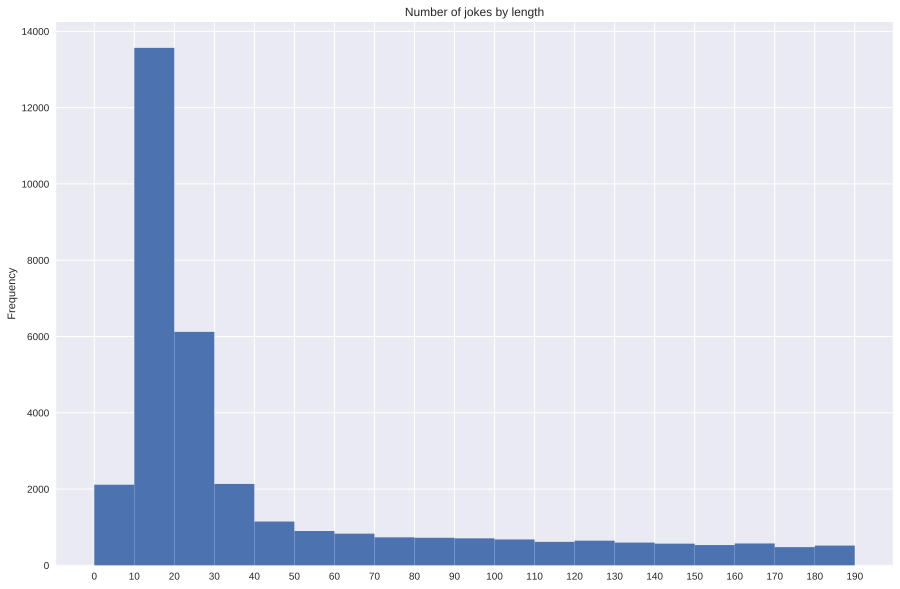

In [8]:
data[(data['rank'] == 4)]['Text_length'].plot(kind='hist', bins=range(0, 200, 10), xticks=range(0, 200,10), figsize=(15, 10), title='Number of jokes by length')
plt.show()

In [9]:
data[(data['rank'] == 4)]['Text_length'].mean()

70.74664508380764

In [10]:
df = data[(data['rank'] == 4) & (data['Text_length'] >= 8) & (data['Text_length'] <=70)]

In [11]:
df.dropna(inplace=True)

In [12]:
df.isna().sum()

id             0
joke           0
rank           0
Text_length    0
dtype: int64

# **Load GPT2 Tokenizer from huggingface's transformers**

In [13]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')


tokenizer.encode("Sample Text")

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[36674, 8255]

### Limit the maximum token length because of RAM limitations.

In [14]:
joke_tokens = pd.DataFrame(df[['joke']].copy())
joke_tokens["len_tokens"] = joke_tokens.applymap(lambda x: len(tokenizer.encode(x)))
joke_tokens = joke_tokens.sort_values("len_tokens", ascending=False)
joke_tokens

,joke,len_tokens
82005,An elderly woman walks into a sex shop. She sl...,174
184005,DICTIONARY FOR DECODING WOMEN'S PERSONAL ADS. ...,159
131672,"shades of grey. #, #, #, #bbb, #ccc, #eee, #,...",150
121900,Are you ready kids? AYE AYE CAPTAIN! I cannot ...,134
47866,"Reading it one time might be not enough.. -""He...",132
...,...,...
175546,Nothing beats a beautiful woman.. Except Chris...,9
148176,I know someone who talks like an owl.,9
175339,Russian nesting dolls are so full of themselves..,9
153599,I cannot stand being in a wheelchair.. ...,9


In [15]:
jokes = joke_tokens.joke[joke_tokens['len_tokens'] <= int(joke_tokens['len_tokens'].max())]
jokes.shape

(26250,)

In [16]:
max_flavour = max([len(tokenizer.encode(joke)) for joke in jokes])

print(f'The longest flavour text is {max_flavour} tokens long.')

The longest flavour text is 174 tokens long.


### **Data Loaders**

In [29]:
bs = 16 # batchsize # 32 was

In [30]:
class JokeDataset(Dataset):
    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_flavour):
        self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:
            """
            This loop will iterate through each entry in the flavour text corpus.
            For each bit of text it will prepend it with the start of text token,
            then append the end of text token and pad to the maximum length with the 
            pad token. 
            """

            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                     truncation=True, 
                                     max_length=max_length, 
                                     padding="max_length")

            """
            Each iteration then appends either the encoded tensor to a list,
            or the attention mask for that encoding to a list. The attention mask is
            a binary list of 1's or 0's which determine whether the langauge model
            should take that token into consideration or not. 
            """
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
dataset = JokeDataset(jokes, tokenizer, max_length=max_flavour)

### **Split into training and validation sets**

In [ ]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {train_size} samples for training, and {val_size} samples for validation testing'

In [32]:
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = bs 
        )

# **Load pretrained GPT2 from huggingface**

In [35]:
# import gc

# gc.collect()

# torch.cuda.empty_cache()

In [36]:
# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)


model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

### **Fine-tune GPT2**

In [37]:
# This step is optional but will enable reproducible runs.
seed_val = 42
seed_everything(seed_val)

In [38]:
epochs = 6
warmup_steps = 1e2
sample_every = 100

In [39]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, 
# and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = 5e-5,  # 5e-4, -- was!
                  eps = 1e-8
                )

In [40]:
"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

### **Train**

In [41]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 6


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:1.0972076654434204. Time:0:02:27
Example output:  bipartisan. business and the $1,000,000. to the $1 million,000. to the


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.7254412174224854. Time:0:04:54
Example output:  increasing with the system has, the system has changed. I am very angry about it. I will not take it. I will not take it. I will not take it. I will not be a man.
, I will not be a man.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.6096698045730591. Time:0:07:21
Example output: dayI was just doing some homework, I thought about my dad saying it, and my dad says, "Well, you'll never understand". That was the first lesson I learned..


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.6269204616546631. Time:0:09:47
Example output:  HangA kid has a dad who loves to tell jokes but wants to stay true to himself.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.49955517053604126. Time:0:12:13
Example output:  foods:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.6988025307655334. Time:0:14:38
Example output:  trail. So he asked, what do you think about the weather? I asked him, "So you think we are weather?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.49875780940055847. Time:0:17:04
Example output: intendHurt.. My parents told me not to wear this.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.49293774366378784. Time:0:19:29
Example output:  surroundHockey.. Not a fan of karate.. but you can still play at the top levelIf you are just trying to make friends.... just


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.5208507180213928. Time:0:21:54
Example output:  reflexWhat do you call a doctor who ignores your advice and is constantly blowing smoke inhalation on your lungs?.  


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.6133688688278198. Time:0:24:19
Example output:  displayWhat do you call a penis on a golf course?. a cork


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.6626513004302979. Time:0:26:44
Example output:  pastorI live in New York City with my wife and two teenage sons. They are playing Xbox and they do not seem very nervous and I ask them why they are playing Xbox. The man replies "The people driving all over town are all using this."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.47702935338020325. Time:0:29:09
Example output:  illicitG. A man tells him about the horrible joke he made at the age of million dollars. A man tells him that his wife, who is the oldest in his family, tells him that he was so fat that she fell into a coma after eating her vegetables. The guy turns to me and says "What did you just say?" I say, "I said, I think she was sick and I thought I should tell her I was sick!"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.5526067614555359. Time:0:31:35
Example output:  LiberationWhen I saw that one guy who stole a pen from a homeless man in an alley....he immediately realized we are talking about our neighbor.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.5446045398712158. Time:0:34:00
Example output:  NamJokes like, "We could all die with nothing" have no meaning. They have already been created.
Average Training Loss: 0.8918359177130336. Epoch time: 0:35:50
Validation loss: 0.5564908173951235. Validation Time: 0:01:19
Beginning epoch 2 of 6


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:0.6950884461402893. Time:0:02:25
Example output: IONI am not kidding when I say that the only way the NSA is going to get  NSA surveillance down is if the NSA gets     to me.... I would have to buy a.50 caliber SONY P. The NSA could always get it, but if I do my job today, it will not be   


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.490297794342041. Time:0:04:51
Example output:  glimpseI came across this old man in the hospital on this morning.... He had an old handkerchief hanging out of his pocket.... And he looked out of the corner of his eye and said: "Where are your friends now?" I asked him. He replied: "I was dead last night."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.6507698893547058. Time:0:07:16
Example output:  LaureA new study shows that men and women have similar mental and physical health problems.. The study published in the journal Am J Epidemiology looked at population of patients who had to suffer from anorexia nervosa. The study found that men with anorexia nervosa had highest rates of mental illness.. The study said there may have been some correlation between men having anorexia and mental illness.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.3790232539176941. Time:0:09:42
Example output: ismDid you hear about the guy in the corner shop with the gun?. Apparently he kept his rifle with him when he wanted to shoot someone.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.6352892518043518. Time:0:12:07
Example output: ounI made a joke about women on the road.. They all said, 'My hair is short, but I also wear top hats. Whoops, i forgot I am black. Sorry guys


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.4272782802581787. Time:0:14:32
Example output:  electionI hate to say this but I still think I am a very good cook...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.4979480803012848. Time:0:16:57
Example output:  crazyI found my father.... So I am in the dark about it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.675762414932251. Time:0:19:21
Example output:  benchThe best time to be a father.. Free View March, February." So I do not want to become a father. "If you cannot make it happen, you are either a man or a woman. If you are married, you are a wife."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.49732697010040283. Time:0:21:46
Example output:  incorporatedA joke. My wife said "Fuck off" to me. She said "Fuck off, it is so fucking funny".


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.5763848423957825. Time:0:24:11
Example output: PeterAs I sat at the library reading a letter that had been written to me today, I suddenly remembered to take a seat.... "I am sorry, how are you feeling?" I asked. "Well, I am doing pretty well!" "But I am not" I told her. "Really?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.5171547532081604. Time:0:26:37
Example output: uringI am having  penises in a bar today. If I get this one, I will let the waitress know how much I appreciate it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.6415692567825317. Time:0:29:02
Example output:  reproductiveMy friend said to me, "if you are going to live with me....you better be doing it yourself!"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.47489452362060547. Time:0:31:27
Example output:  zoneA man is holding a gun in his pants and screams "stop fucking!" "You cannot hear me this time!"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.3607317805290222. Time:0:33:51
Example output:  commitsCant remember the joke about the clock keeping up?. Because it is a fucking clock.
Average Training Loss: 0.5438566445577927. Epoch time: 0:35:42
Validation loss: 0.5285824997858568. Validation Time: 0:01:19
Beginning epoch 3 of 6


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:0.6066022515296936. Time:0:02:25
Example output:  ironyA Jewish joke. An older man walks into an alcoholic bar.. "Hi there!" The bartender looks at him and says, "What do you have?" "What are you trying to say?" A Jewish man says, "I got an Irish joke." The bartender looks up and says "What the hell did you get?" The man then proceeds to ask him, "Your friend had one. Which one?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.44442304968833923. Time:0:04:50
Example output:  SahI went to the doctor. He was concerned that my nose was getting a little on the sensitive side.. Apparently, it was just the tip of the tongue that was sensitive. "So how do you feel about that nose?" I asked.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.557339072227478. Time:0:07:16
Example output:  BryanI heard the police were investigating a man for impersonating a prostitute on the bus. Turns out there were many different kinds of people doing it..


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.5000784397125244. Time:0:09:40
Example output:  spiritsWhat is the difference between a pedophile's penis and a nudist's penis?. The nudist's dick is pretty small


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.42982935905456543. Time:0:12:05
Example output:  seesWhy do the hippies have no windows?. Because they know how to hang.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.5218380689620972. Time:0:14:30
Example output:  hungryDid you hear about the new school of thermals?. They can run all day long


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.4846982955932617. Time:0:16:56
Example output:  PTWhat do a frog and a bee have in common?. They have two eyes.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.5765169858932495. Time:0:19:22
Example output: üWhat is the difference between Jesus Christ and Satan?. Satan does not eat dead horses.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.49930286407470703. Time:0:21:48
Example output: ruceWhat is a man and a woman like on a beach?. A beach.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.43858492374420166. Time:0:24:15
Example output:  derivativesYou do not want to make a joke about racism.. But you do want to make a joke about America, and you hate racism.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.49625056982040405. Time:0:26:41
Example output: What did the guy who ate too much crack have to go to prison?. A long-term hold.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.5063174366950989. Time:0:29:07
Example output:  rememberingWhat do you call a blind man who steals  condoms?. A pirate


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.5887724757194519. Time:0:31:32
Example output:  SourcesWhy did the priest go missing?. He was really drunk.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.48366934061050415. Time:0:33:58
Example output: emsA man was walking on a field when he saw a car come down, turn and smash into him!. "Wow!" screamed his girlfriend. "Wow! That is the driver!"
Average Training Loss: 0.5090682677263817. Epoch time: 0:35:50
Validation loss: 0.5128923080184243. Validation Time: 0:01:19
Beginning epoch 4 of 6


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:0.40941131114959717. Time:0:02:26
Example output: tzWhat does the best Jewish joke do?. Tell Us, Us.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.44779905676841736. Time:0:04:51
Example output: maticWhy do Indians always go to church early?. They are hungry


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.4445883333683014. Time:0:07:16
Example output:  syndA woman was sitting at a corner table at a coffee shop.......and suddenly a man walks over, pulls out a pen, and starts writing a note.... He points and says, "I cannot spell it right now, I can not stop writing this." The woman replies, "Not really."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.46767616271972656. Time:0:09:42
Example output:  gamA Muslim walks into a bar and says to a girl who is waiting for him.... "Can I have my drink please?". The girl says, "Sir, no, sir, just buy me a drink".


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.48802730441093445. Time:0:12:07
Example output:  injuryWhy do Scots always have  balls?. If they do not, the ball will not come


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.4089435636997223. Time:0:14:33
Example output: azaWhat do you call a pirate who cannot make love?. A dumpling


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.40275996923446655. Time:0:16:58
Example output:  membraneThe unthinkable. A man says to his wife, "I have a dog.... A dog is a very powerful weapon. I just need to get it out of my dogs hands." He is right, she has got it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.4689957797527313. Time:0:19:24
Example output: ijingI am always going to try something crazy.... I am always going to try something crazy.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.489301472902298. Time:0:21:49
Example output:  castDid you know that one person in the world can change its mind?. It just takes a village to change.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.589543879032135. Time:0:24:14
Example output:  purchDid you hear about the guy that invented the term "sugar" and is now known for his work?. He is a big soda guy.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.3539094030857086. Time:0:26:40
Example output:  shouldersWhy did not the chicken go to bed early?. Because he was not yet fat enough to eat.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.5091739892959595. Time:0:29:04
Example output:  builtWhat do you call a girl who runs faster than her husband on a freeway?. Mrs. Taurus


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.5864365696907043. Time:0:31:30
Example output:  openlyWho do you want to be with when you die?. Your family


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.31783419847488403. Time:0:33:55
Example output:  haltedA couple of my favorite Pokemon were in the fridge. I did not expect such a thing!.
Average Training Loss: 0.4826483026338576. Epoch time: 0:35:46
Validation loss: 0.5030023802410473. Validation Time: 0:01:19
Beginning epoch 5 of 6


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:0.41829589009284973. Time:0:02:25
Example output:  NikI thought my roommate had just gotten a degree.... But I did not expect to receive a degree from him


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.462069034576416. Time:0:04:51
Example output:  tinIf you were  inches taller.... you would be  inches taller now


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.4682210683822632. Time:0:07:16
Example output:  clinicalMy wife is a pretty well dressed woman.. She is also a pretty well dressed lady. She wears both an electric guitar and a turntable. It is a bit expensive, but most of the time she is putting on her hair and keeps on playing nice.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.6190449595451355. Time:0:09:42
Example output: lectionsWhat did the leper say to the prostitute?. I will see myself out.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.39326971769332886. Time:0:12:07
Example output: elsMy dad tells me I have an awesome penis.... He said "What?" I said "No, but how does it feel when you touch my asshole?" He said "It feels great". Then he said "You should stop looking down your nose."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.4237104654312134. Time:0:14:33
Example output: labA blind man walks into a bar.... A blind man walks into a bar with a beautiful brunette looking woman sitting at the side of the bar with him. He leans over and says "hey, can we have a drink?" The brunette asks "sure" The man replies "oh, thanks"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.39128774404525757. Time:0:16:59
Example output:  tripleMy favorite animal. What is it called? A leopard.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.3270544409751892. Time:0:19:24
Example output: 220A priest with a black eye and a sad face walks into a bar.... The bartender looks at his watch and says, "We do not serve black people here." "Well, it is nothing to do with me."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.4259127974510193. Time:0:21:50
Example output:  SeeWhat is the difference between a hooker and a prostitute?. A hooker gets laid three times.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.5004978775978088. Time:0:24:15
Example output: @@A woman in the supermarket asks the lady, "Is there anything to buy for  dollars?". "No," the lady replies, "but there is a cow at the bar. What do you want him for?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.4171328544616699. Time:0:26:41
Example output:  hostWhat is the most dangerous kind of dog?. A Labrador.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.4500042796134949. Time:0:29:06
Example output: roleIf I had  cents for every time I slept in a bar stool.... I would be a millionaire.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.5460114479064941. Time:0:31:31
Example output: iacA man is sitting on his hands and knees with a beautiful bird in his lap.... The bird tells him to go down on it, but the man says "go over to the back of the house!". The bird says "get the hell out"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.3685624897480011. Time:0:33:57
Example output:  LDWhat Is the worst part of having to go to the doctor for an operation?. Having to go up to the doctor.
Average Training Loss: 0.4625064880967382. Epoch time: 0:35:48
Validation loss: 0.4973907187129512. Validation Time: 0:01:19
Beginning epoch 6 of 6


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 1477. Loss:0.47497740387916565. Time:0:02:25
Example output:  ListenI have lost both my glasses and a Rolex.... So i am taking them off to save money.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 1477. Loss:0.3359256684780121. Time:0:04:49
Example output:  dyI bought a bottle of Viagra to protect against poo.... I do not know why I bought it, but it smells good!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 1477. Loss:0.4502268433570862. Time:0:07:14
Example output:  DomesticTwo kids were playing. One said to the other, "Hey, dad, are you playing outside?" The other parent responded, "What the fuck is going on?"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 1477. Loss:0.38793128728866577. Time:0:09:39
Example output:  beneficiariesWhat is the difference between a Jew and a racist joke?. I do not know, I do not live in a ghetto.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 1477. Loss:0.425792932510376. Time:0:12:04
Example output:  TitleWhy did the blind man jump off the Empire State Building?. To save face


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 1477. Loss:0.3822595179080963. Time:0:14:28
Example output:  μMy wife told me my sexual fetishes and she really enjoyed them all, when I said "I love you" she looked up.. I think she meant the words "I want to fuck"


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 1477. Loss:0.43918222188949585. Time:0:16:53
Example output:  sellingMy wife was like that when I got pregnant.. She was a perfect match for my body.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 1477. Loss:0.5015331506729126. Time:0:19:18
Example output:  migrantWhy do not you hear about the Mexican who lost his job at the border?. He got a new one, and he is still here.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 1477. Loss:0.5949856638908386. Time:0:21:42
Example output: ivelyWhat do a duck tell his girlfriend?. She is an asshole.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 1477. Loss:0.4539644122123718. Time:0:24:07
Example output:  orderWhat is the difference between a pedophile and a terrorist?. The pedophiles cannot climb stairs.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 1477. Loss:0.4587778151035309. Time:0:26:31
Example output:  VPNWho did the egg eat that came with  bananas?. I do not know, but i would have given them the honour to head over.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 1477. Loss:0.4068939983844757. Time:0:28:56
Example output:  explanationA young man walks into a bar. "Hello?" asked the bartender. "Yessir, does your hair come in any braids?" "No," replied the young man, "I wish."


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 1477. Loss:0.3908082842826843. Time:0:31:21
Example output:  BachWhat do you call an idiot when his mother dies?. A Decaf.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 1477. Loss:0.3399384021759033. Time:0:33:45
Example output:  folderWhat is the difference between a drunk driver and a hipster?. One's a lot of fun to have with his friends
Average Training Loss: 0.449438400178159. Epoch time: 0:35:35
Validation loss: 0.49627532055883694. Validation Time: 0:01:18
Total training took 3:42:25


### **Visualization**

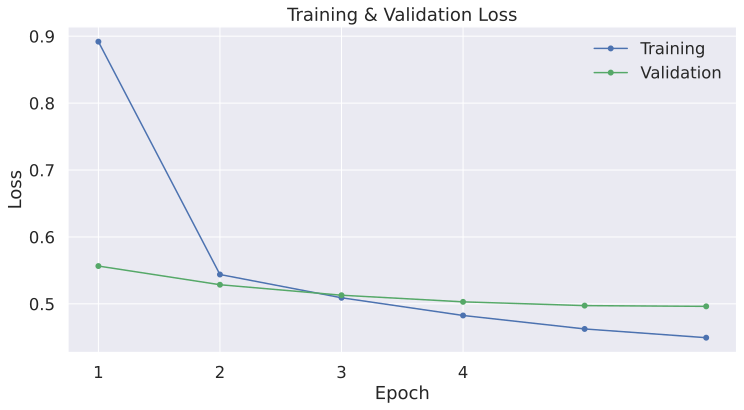

In [42]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### **Generation**

In [43]:
model.eval()
seed_everything(42)

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=25 # if set then no sample?
                                )

for i, sample_output in enumerate(sample_outputs):
    print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Why did the blonde wear glasses at the party?. To stay on the right side of the screen, while wearing glasses.


1: How do you make your pants look like Jesus?. With an iron!


2: When I asked my daughter the time of day, she replied "Every  minutes". I think she means she is going to be eating lunch on the way home.


3: A blonde chick went to the dentist.. He told her he needs dental records for both her teeth. She told him there are two more to go. "I will just give them to you, and you will know," he said. She laughed and said, "sure, but what about the two teeth?"


4: I used to be a pretty bad cook. But I now just like my vegetables.


5: A man is going through the motions when he thinks about what he has just done.. I want to see what he was all those years ago.


6: A guy goes to the doctor with a case of diarrhea.. Doctor: What the heck is wrong with you? Guy: I am sick and tired of the "do not talk about it" attitude.


7: I am going to have sex with  of my friends next mo

### **Save Model**

In [ ]:
output_dir = '/content/drive/My Drive/NLP_humor/models_v3/'

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/drive/My Drive/NLP_humor/models_v2/tokenizer_config.json',
 '/content/drive/My Drive/NLP_humor/models_v2/special_tokens_map.json',
 '/content/drive/My Drive/NLP_humor/models_v2/vocab.json',
 '/content/drive/My Drive/NLP_humor/models_v2/merges.txt',
 '/content/drive/My Drive/NLP_humor/models_v2/added_tokens.json')